In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os as os
os.chdir('/media/shubham/04505A8E505A85F8/Data Science/Big Mart')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

/home/shubham/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
### mean imputations
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace=True)
#test.isnull().sum()

In [4]:
### reducing fat content to only two categories
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat'])
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], ['Regular'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])
train['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [5]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])

In [6]:
train['Item_Visibility'] = train['Item_Visibility'].replace(0,np.mean(train['Item_Visibility']))
test['Item_Visibility'] = test['Item_Visibility'].replace(0, np.mean(test['Item_Visibility']))
#test['Item_Visibility'] = np.log(test['Item_Visibility'])

In [7]:
from scipy.stats import boxcox
#train['Item_Visibility'] = np.log(train['Item_Visibility'])

In [8]:
train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year']

In [9]:
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year']

In [10]:
## binning of mrp with a new variable price
#train['Price'] = 0
#bins = [0, 93, 143, 185, 267]
#group_names = ['Very Low', 'Low', 'Medium', 'HIGH']
#train['Price'] = pd.cut(train['Item_MRP'], bins, labels=group_names)
#train.Price.value_counts()

In [11]:
train['Outlet_Location_Type'] = train['Outlet_Location_Type'].astype('category')
train['Outlet_Type'] = train['Outlet_Type'].astype('category')
train['Outlet_Size'] = train['Outlet_Size'].astype('category')
#train.info()

In [12]:
test['Outlet_Location_Type'] = test['Outlet_Location_Type'].astype('category')
test['Outlet_Type'] = test['Outlet_Type'].astype('category')
test['Outlet_Size'] = test['Outlet_Size'].astype('category')

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

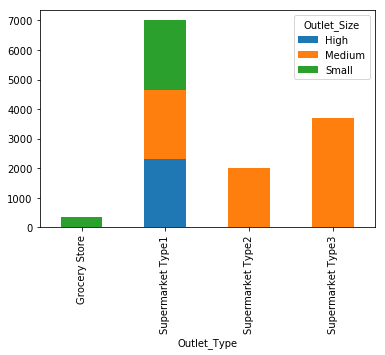

In [13]:
temp = train.pivot_table(values='Item_Outlet_Sales', index='Outlet_Type', columns='Outlet_Size', aggfunc='mean')
temp.plot(kind='bar', stacked=True)
train.isnull().sum()

In [14]:
### imputations of outlet size
train.loc[(pd.isnull(train.Outlet_Size)) & (train.Outlet_Type == 'Grocery Store'), 'Outlet_Size'] = 'Small'

In [15]:
test.loc[(pd.isnull(test.Outlet_Size)) & (test.Outlet_Type == 'Grocery Store'), 'Outlet_Size'] = 'Small'

In [16]:
(pd.isnull(train.Outlet_Size) & (train.Outlet_Location_Type == 'Tier 2')).sum()

1855

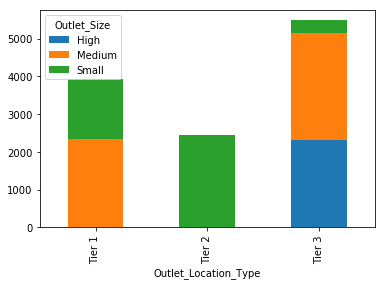

In [17]:
temp = train.pivot_table(values='Item_Outlet_Sales', index='Outlet_Location_Type', columns='Outlet_Size', aggfunc='mean')
temp.plot(kind='bar', stacked=True)

In [18]:
### imputation based on location type
train.loc[ (pd.isnull(train.Outlet_Size)) & (train.Outlet_Location_Type == 'Tier 2') ,'Outlet_Size'] = 'Small'
### checking missing values left
train.Outlet_Size.isnull().sum()

0

In [19]:
test.loc[ (pd.isnull(test.Outlet_Size)) & (test.Outlet_Location_Type == 'Tier 2') ,'Outlet_Size'] = 'Small'
### checking missing values left
test.Outlet_Size.isnull().sum()

0

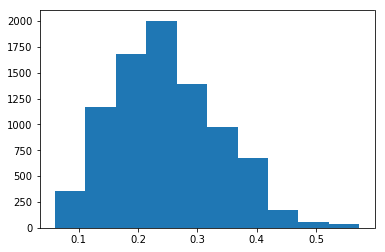

In [20]:
#### skewness handling
plt.hist(np.sqrt(train.Item_Visibility))
train['Item_Visibility'] = np.sqrt(train['Item_Visibility'])
test['Item_Visibility'] = np.sqrt(test['Item_Visibility'])

In [21]:
### creating dummy variables
#train.Item_Weight.describe()
#df = pd.cut(train.Item_Weight, [0,9.31,16,22] , labels = ['weight_low','weight_medium', 'weight_high'])
#dummy = pd.get_dummies(df)
#dummy

In [25]:
### concat dummy varible with train
#train = pd.concat([train,dummy], axis = 1)

In [26]:
## one hot encoding
two_hot = pd.get_dummies(train['Outlet_Location_Type'], prefix = 'Outlet_Location_Type')
#two_hot.drop(['Outlet_Location_Type_Tier 1'], axis=1, inplace=True)
#two_hot.isnull().sum()

In [176]:
### one hot encoding
one_hot = pd.get_dummies(train['Outlet_Size'], prefix = 'Outlet_Size')
#one_hot.drop(['Outlet_Size_High'],axis=1,inplace=True)

three_hot = pd.get_dummies(train['Outlet_Type'], prefix = 'Outlet_Type')
three_hot.head()
one_hot = pd.concat([one_hot,two_hot,three_hot], axis = 1)
one_hot.isnull().sum()

Outlet_Size_High                 0
Outlet_Size_Medium               0
Outlet_Size_Small                0
Outlet_Location_Type_Tier 1      0
Outlet_Location_Type_Tier 2      0
Outlet_Location_Type_Tier 3      0
Outlet_Type_Grocery Store        0
Outlet_Type_Supermarket Type1    0
Outlet_Type_Supermarket Type2    0
Outlet_Type_Supermarket Type3    0
dtype: int64

In [177]:
## for test
two_hot1 = pd.get_dummies(test['Outlet_Location_Type'], prefix = 'Outlet_Location_Type')
#two_hot1.drop(['Outlet_Location_Type_Tier 1'], axis=1, inplace=True)
one_hot1 = pd.get_dummies(test['Outlet_Size'], prefix = 'Outlet_Size')
#one_hot1.drop(['Outlet_Size_High'],axis=1,inplace=True)
three_hot1 = pd.get_dummies(test['Outlet_Type'], prefix = 'Outlet_Type')
one_hot1 = pd.concat([one_hot1,two_hot1,three_hot1], axis = 1)
test = pd.concat([test,one_hot1], axis=1)

In [178]:
train = pd.concat([train,one_hot], axis=1)
#train.isnull().sum()

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null category
Outlet_Location_Type         8523 non-null category
Outlet_Type                  8523 non-null category
Item_Outlet_Sales            8523 non-null float64
dtypes: category(3), float64(4), int64(1), object(4)
memory usage: 624.7+ KB


In [22]:
## using label enconder for Item fat content
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
train['Item_Fat_Content'] = number.fit_transform(train['Item_Fat_Content'].astype('str'))

In [23]:
test['Item_Fat_Content'] = number.fit_transform(test['Item_Fat_Content'].astype('str'))

In [24]:
train['Outlet_Size'].dtype == 'category'

True

In [25]:
col = ['Outlet_Size','Outlet_Location_Type','Outlet_Type']
test['Item_Outlet_Sales'] = 0
combi = train.append(test)
for i in col:
        combi[i] = number.fit_transform(combi[i].astype('str'))
        combi[i] = combi[i].astype('object')
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]
test.drop('Item_Outlet_Sales',axis=1,inplace=True)

/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
## feature engg
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null int64
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 865.6+ KB


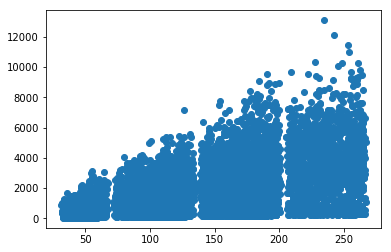

In [184]:
plt.scatter(train['Item_MRP'],train['Item_Outlet_Sales'])

In [185]:
# binning of mrp
train['price'] = 0
bins = [0,65,140,210,300]
label = ['low','med','high','very high']
train['price'] = pd.cut(train['Item_MRP'], bins=bins, labels=label)
train['price'] = number.fit_transform(train['price'].astype('str'))

In [186]:
test['price'] = 0
bins = [0,65,140,210,300]
label = ['low','med','high','very high']
test['price'] = pd.cut(test['Item_MRP'], bins=bins, labels=label)
test['price'] = number.fit_transform(test['price'].astype('str'))

In [187]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,cat,price
0,FDA15,9.30,0,0.126678,Dairy,249.8092,OUT049,14,Medium,Tier 1,...,0,1,0,0,0,1,0,0,1,3
1,DRC01,5.92,1,0.138846,Soft Drinks,48.2692,OUT018,4,Medium,Tier 3,...,0,0,0,1,0,0,1,0,0,1
2,FDN15,17.50,0,0.129461,Meat,141.6180,OUT049,14,Medium,Tier 1,...,0,1,0,0,0,1,0,0,1,0
3,FDX07,19.20,1,0.257161,Fruits and Vegetables,182.0950,OUT010,15,Small,Tier 3,...,1,0,0,1,1,0,0,0,1,0
4,NCD19,8.93,0,0.257161,Household,53.8614,OUT013,26,High,Tier 3,...,0,0,0,1,0,1,0,0,2,1


In [ ]:
## avg sales using item type
sales_item = pd.DataFrame(train[['Item_Type','Item_Outlet_Sales']].groupby('Item_Type')['Item_Outlet_Sales'].apply(lambda x: np.average(x))).reset_index()
sales_item.columns = ['Item_Type','Avg_Sales']

In [ ]:
train = pd.merge(train,sales_item,on='Item_Type',how='left')
test = pd.merge(test,sales_item,on='Item_Type',how='left')

In [190]:
## count of item type
outlet_wise_items = pd.DataFrame(train[['Outlet_Identifier','Item_Type']].groupby('Outlet_Identifier')['Item_Type'].value_counts())

In [191]:
outlet_wise_items = outlet_wise_items.rename(columns = {'Item_Type':'Outlet_wise_items'})

In [192]:
outlet_wise_items = outlet_wise_items.reset_index()

In [193]:
train = pd.merge(train,outlet_wise_items,on=['Outlet_Identifier','Item_Type'],how='left')
test = pd.merge(test,outlet_wise_items,on=['Outlet_Identifier','Item_Type'],how='left')

In [195]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,cat,price,Avg_Sales,Outlet_wise_items
0,FDA15,9.30,0,0.126678,Dairy,249.8092,OUT049,14,Medium,Tier 1,...,0,0,0,1,0,0,1,3,2232.542597,78
1,DRC01,5.92,1,0.138846,Soft Drinks,48.2692,OUT018,4,Medium,Tier 3,...,0,1,0,0,1,0,0,1,2006.511735,46
2,FDN15,17.50,0,0.129461,Meat,141.6180,OUT049,14,Medium,Tier 1,...,0,0,0,1,0,0,1,0,2158.977911,47
3,FDX07,19.20,1,0.257161,Fruits and Vegetables,182.0950,OUT010,15,Small,Tier 3,...,0,1,1,0,0,0,1,0,2289.009592,79
4,NCD19,8.93,0,0.257161,Household,53.8614,OUT013,26,High,Tier 3,...,0,1,0,1,0,0,2,1,2258.784300,103


In [242]:
Item_type_count = pd.DataFrame(train[['Item_Identifier','Item_Type']].groupby('Item_Type')['Item_Identifier'].apply(lambda x: len(x))).reset_index()
Item_type_count= Item_type_count.rename(columns = {'Item_Identifier':'Item_count'})
train = pd.merge(train,Item_type_count,on='Item_Type',how='left')
test = pd.merge(test,Item_type_count,on='Item_Type',how='left')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null int64
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 865.6+ KB


In [26]:
### using tpot library
tpot_train = train.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
tpot_test = test.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
target = tpot_train['Item_Outlet_Sales']
tpot_train.drop('Item_Outlet_Sales',axis=1,inplace=True)

In [27]:
from tpot import TPOTRegressor
X_train, X_test, y_train, y_test = train_test_split(tpot_train, target,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_boston_pipeline.py')

Optimization Progress:  32%|███▏      | 95/300 [02:02<02:39,  1.29pipeline/s]

Generation 1 - Current best internal CV score: 1200051.9570798785


Optimization Progress:  46%|████▋     | 139/300 [02:45<02:45,  1.03s/pipeline]

Generation 2 - Current best internal CV score: 1200051.9570798785


Optimization Progress:  62%|██████▏   | 186/300 [03:40<02:15,  1.19s/pipeline]

Generation 3 - Current best internal CV score: 1200051.9570798785


Optimization Progress:  77%|███████▋  | 231/300 [04:56<01:25,  1.24s/pipeline]

Generation 4 - Current best internal CV score: 1200051.9570798785


Generation 5 - Current best internal CV score: 1198069.2286886068

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=DEFAULT, ExtraTreesRegressor__min_samples_leaf=18, ExtraTreesRegressor__min_samples_split=15, ExtraTreesRegressor__n_estimators=100)
1070830.51172


In [49]:
##checking overfitting
from sklearn.ensemble import ExtraTreesRegressor

In [50]:
etr = ExtraTreesRegressor(bootstrap=True, max_features=0.90, min_samples_leaf=20, min_samples_split=17, n_estimators=100)

In [51]:
etr.fit(tpot_train,target)
etr_pred = etr.predict(tpot_test)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(tpot_train, target,
                                                    train_size=0.7, test_size=0.3)

In [65]:
etr.fit(X_train,y_train)
(cross_val_score(etr, X_test, y_test, cv=10, scoring='neg_mean_squared_error'))

array([-1265174.83405722, -1235784.98789213, -1192637.72696121,
        -962346.81337446, -1502741.12436571, -1155028.76097615,
       -1181381.65475273, -1181064.17294361, -1242556.32726437,
       -1085912.06184729])

In [63]:
cross_val_score(etr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

array([ -999730.78877877, -1064386.21997834, -1126438.97194846,
       -1133099.42961925, -1238585.76002893, -1216240.56601463,
       -1083924.91837044, -1241289.67424673, -1181424.86751519,
       -1258483.64220954])

In [42]:
tpot.score(tpot_train,target)

1120297.3059152924

In [47]:
tpot_pred = tpot.predict(tpot_test)

In [52]:
sub1 = pd.DataFrame(data=etr_pred)
#sub1.index = np.arange(0, len(test)+1)
sub1 = sub1.rename(columns = {'0':'Item_Outlet_Sales'})
sub1['Item_Identifier'] = test['Item_Identifier']
sub1['Outlet_Identifier'] = test['Outlet_Identifier']
sub1.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub1 = sub1[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub1.to_csv('etr.csv',index=False)

In [247]:
train1 = train.drop(['Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)

In [248]:
test1 = test.drop(['Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)

In [44]:
# import sklearn
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
from sklearn.model_selection import train_test_split

In [45]:
X = train1.drop('Item_Outlet_Sales',1)
target = train1['Item_Outlet_Sales']
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,cat,price,Avg_Sales,Outlet_wise_items
0,9.30,0,0.126678,249.8092,14,0,1,0,1,0,0,0,1,0,0,1,3,2232.542597,78
1,5.92,1,0.138846,48.2692,4,0,1,0,0,0,1,0,0,1,0,0,1,2006.511735,46
2,17.50,0,0.129461,141.6180,14,0,1,0,1,0,0,0,1,0,0,1,0,2158.977911,47
3,19.20,1,0.257161,182.0950,15,0,0,1,0,0,1,1,0,0,0,1,0,2289.009592,79
4,8.93,0,0.257161,53.8614,26,1,0,0,0,0,1,0,1,0,0,2,1,2258.784300,103


In [46]:
### split train to cross validate
x_train, x_test, y_train, y_test = train_test_split(X,train.Item_Outlet_Sales)

In [44]:
cross_val_score(lreg,train1,target,cv=5,scoring='neg_mean_squared_error')

array([ -1.82994511e-24,  -3.26042341e-24,  -4.28049148e-24,
        -1.53495056e-24,  -1.00870466e-24])

In [45]:
### training a linear regression model on train 
lreg.fit(x_train,y_train)
pred_cv = lreg.predict(x_test)
print (np.sqrt((np.mean(y_test - pred_cv)**2)))

4.42257324957


In [46]:
### predicting on test data
lreg.fit(X,train.Item_Outlet_Sales)
pred_test = lreg.predict(test1)
sub = pd.DataFrame(data=pred_test)
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']

In [47]:
sub.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub = sub[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub.to_csv('lreg.csv',index=False)

1201

# Lasso

In [48]:
from sklearn.linear_model import Lasso
for a in [0.1,0.3,0.5,0.7,0.9]:
    lasso = Lasso(alpha = a)
    lasso.fit(x_train,y_train)
    lasso_pred = lasso.predict(x_test)
    print (a,np.sqrt(mean_squared_error(y_test,lasso_pred)))

/home/shubham/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.1 1157.91609692
0.3 1158.25618676
0.5 1158.64955937
0.7 1158.90420797
0.9 1158.94724488


In [158]:
lasso = Lasso(alpha=0.7)
lasso.fit(train1.drop('Item_Outlet_Sales',axis=1),target)
lasso_pred = lasso.predict(test1)
lasso_tpred = lasso.predict(train1.drop('Item_Outlet_Sales',axis=1))
sub = pd.DataFrame(data=lasso_pred)
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub = sub[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub.to_csv('lasso.csv',index=False)

rmse = 1203

# Random Forest

In [50]:
for n in [100,300,500]:
    for depth in [6,8,10,12,14]:
       # for sample in [2,4,5,6]:
            rf = RandomForestRegressor(n_estimators=n,max_depth=depth,min_samples_leaf=50,oob_score=True)
            rf.fit(x_train,y_train)
            pred = rf.predict(x_test)
            print (n,depth,np.sqrt(mean_squared_error(y_test,pred)))

100 6 1108.49129548
100 8 1111.20820345
100 10 1110.94864168
100 12 1109.87906345
100 14 1112.08744804
300 6 1107.97504485
300 8 1110.83468114
300 10 1111.96841415
300 12 1110.57081813
300 14 1111.37453182
500 6 1107.93233833
500 8 1110.82702951
500 10 1111.70522561
500 12 1110.8037384
500 14 1110.7951966


In [253]:
# for min sample leaf
for sample in [20,30,50]:
    rf = RandomForestRegressor(n_estimators=500,max_depth=6,min_samples_leaf=sample,oob_score=True)
    rf.fit(x_train,y_train)
    pred = rf.predict(x_test)
    print (sample,np.sqrt(mean_squared_error(y_test,pred)))

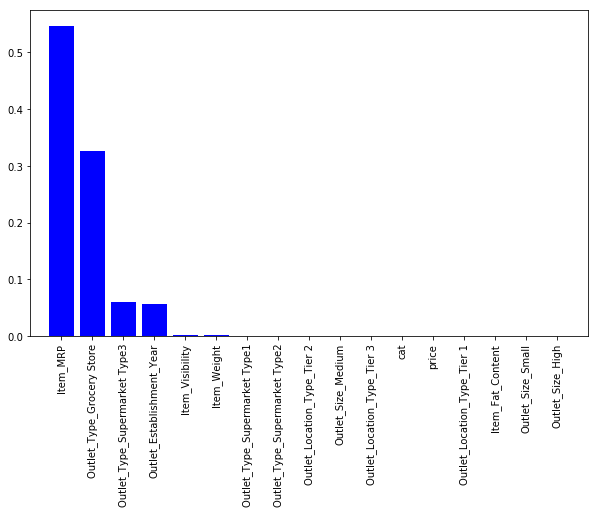

In [52]:
## plotting importance
features = x_train.columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(10,6))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

In [159]:
rf = RandomForestRegressor(n_estimators=500,max_depth=6,min_samples_leaf=30,oob_score=True)
rf.fit(train1.drop('Item_Outlet_Sales',axis=1),target)
rf_pred = rf.predict(test1)
rf_tpred = rf.predict(train1.drop('Item_Outlet_Sales',axis=1))
sub = pd.DataFrame(data=rf_pred)
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub = sub[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub.to_csv('rf.csv',index=False)

n=400, depth = 6, min_sample_leaf = 4, rmse = 1157 !!!!!!!!!!!!!
min_sample_leaf =30, rmse= 1155

In [84]:
#xgb
import xgboost as xgb
xgb_para = {
    
    'eta':0.05,
    'max_depth':6,
    'subsample':0.75,
    'objective':'reg:linear',
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'eval_metric':'rmse',
}

In [85]:
#Dmatrix
dtrain = xgb.DMatrix(train1.drop(['Item_Outlet_Sales'], axis=1), target)
dtest = xgb.DMatrix(test1)

In [86]:
#xgboost cv
cv_result = xgb.cv(xgb_para,
                   dtrain,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=50,
                   show_stdv=False)
num_boost_rounds = len(cv_result)
print (num_boost_rounds)

model = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)

[0]	train-rmse:2653.93	test-rmse:2654.18
[50]	train-rmse:1027.59	test-rmse:1110.15
[100]	train-rmse:942.387	test-rmse:1100.1
76


In [74]:
# making pred
xgb_pred = model.predict(dtest)
sub = pd.DataFrame(data=xgb_pred)
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub = sub[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub.to_csv('xgb.csv',index=False)

In [230]:
##LGB
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.0045 , #small learn rate, large number of iterations
    'verbose': 0,
    'num_iterations': 500,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 42,
    'feature_fraction': 0.95,
    'feature_fraction_seed': 42,
    'max_bin': 100,
    'max_depth': 3,
    'num_rounds': 800
}

In [249]:
import lightgbm as lgb
train_data=lgb.Dataset(train1.drop('Item_Outlet_Sales',axis=1),label=(train1['Item_Outlet_Sales']/train1['Item_MRP']))
#training our model using light gbm
num_round=2000
lgbm=lgb.train(params,
               train_data,
               num_round)
#predicting on test set
lgbm_predict = lgbm.predict(test1)
lgbm_tpred = lgbm.predict(train1.drop('Item_Outlet_Sales', axis=1))
lgbm_predict[:5]

array([ 15.60741121,  16.3327818 ,   2.71929881,  16.81773888,  25.94402026])

In [250]:
lgbm_predict = lgbm_predict*test1['Item_MRP']
sub = pd.DataFrame(data=lgbm_predict)
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub = sub[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub.to_csv('lgbm.csv',index=False)

In [137]:
##stacking using LGB
strain1 = train1[0:4000]
strain2 = train1[4001:]

In [139]:
#model on 1
strain1_lgb = lgb.Dataset(strain1.drop('Item_Outlet_Sales',axis=1), label=strain1['Item_Outlet_Sales'])
lgbm = lgb.train(params,strain1_lgb, num_round)
lgb_pred1 = lgbm.predict(strain2)
lgb_predt1 = lgbm.predict(test1)

In [140]:
#model on 2
strain2_lgb = lgb.Dataset(strain2.drop('Item_Outlet_Sales',axis=1), label=strain2['Item_Outlet_Sales'])
lgbm = lgb.train(params,strain2_lgb, num_round)
lgb_pred2 = lgbm.predict(strain1)
lgb_predt2 = lgbm.predict(test1)

In [141]:
strain1['pred'] = lgb_pred2
strain2['pred'] = lgb_pred1
test1['pred'] = (lgb_predt1 + lgb_predt2)/2
final_strain = strain1.append(strain2)

/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/shubham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [142]:
final_train_data = lgb.Dataset(final_strain.drop('Item_Outlet_Sales',axis=1),label=final_strain['Item_Outlet_Sales'])

In [148]:
num_round=2000
lgbm_stack =lgb.train(params,
               final_train_data,
               num_round)

In [149]:
lgbm_predict = lgbm_stack.predict(test1)
sub = pd.read_csv('rf.csv')
sub['Item_Outlet_Sales'] = lgbm_predict
sub.to_csv('stacking.csv')

In [147]:
## stack lgb + lasso + rf and then avg with xgboost

In [162]:
pred = pd.DataFrame(data= train['Item_Outlet_Sales'])

In [164]:
pred['rf'] = rf_tpred
pred['lasso'] = lasso_tpred
pred['lgbm'] = lgbm_tpred

In [166]:
pred.head()

,Item_Outlet_Sales,rf,lasso,lgbm
0,3735.1380,4148.906889,4019.122394,4236.795066
1,443.4228,755.991181,593.007047,595.186736
2,2097.2700,2135.033695,2373.483508,2249.829689
3,732.3800,513.005050,1053.017054,500.617005
4,994.7052,830.877350,910.872720,845.544163


In [168]:
prediction = (rf_pred + lasso_pred + lgbm_predict)/3
sub['Item_Outlet_Sales'] = prediction
sub.to_csv('stacking.csv')

In [171]:
test_pred = pd.DataFrame(data=rf_pred)

In [173]:
test_pred.columns = ['rf']
test_pred['lasso'] = lasso_pred
test_pred['lgbm'] = lgbm_predict
test_pred.head()

,rf,lasso,lgbm
0,1648.097430,1816.314965,1578.112586
1,1362.104497,1526.190320,1404.355123
2,591.151102,1885.555009,591.272101
3,2487.556910,2568.861302,2535.673171
4,6221.179593,5161.768795,6082.382690


In [174]:
## avg with xgboost

In [214]:
y_mean = np.mean(pred['Item_Outlet_Sales'])
params = {
    'eta': 0.005,
    'max_depth': 3,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

In [215]:
dtrain = xgb.DMatrix(pred.drop('Item_Outlet_Sales',axis=1), pred['Item_Outlet_Sales'])
dtest = xgb.DMatrix(test_pred)

In [216]:
#xgboost cv
cv_result = xgb.cv(params,
                   dtrain,
                   num_boost_round=2000,
                   early_stopping_rounds=50,
                   verbose_eval=200,
                   show_stdv=False)
num_boost_rounds = len(cv_result)
print (num_boost_rounds)

model = xgb.train(dict(params), dtrain,num_boost_round=num_boost_rounds)

[0]	train-rmse:1700.87	test-rmse:1700.86
[200]	train-rmse:1110.73	test-rmse:1122.41
[400]	train-rmse:986.887	test-rmse:1006.2
[600]	train-rmse:959.675	test-rmse:987.241
[800]	train-rmse:947.892	test-rmse:984.07
924


In [217]:
prediction = model.predict(dtest)
sub['Item_Outlet_Sales'] = prediction
sub.to_csv('stacking.csv')

In [198]:
train_pred = model.predict(dtrain)

In [199]:
#pred['avg'] = train_pred
np.sqrt(mean_squared_error(pred['Item_Outlet_Sales'],train_pred))

949.58901466030466

In [75]:
## blending
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [140]:
np.random.seed(0)  # seed to shuffle the train set

n_folds = 5
verbose = True
shuffle = False

X = train1.drop('Item_Outlet_Sales',axis=1)
y = train1['Item_Outlet_Sales']
X_submission = test1

In [141]:
if shuffle:
    idx = np.random.permutation(y.size)
    X = X[idx]
    y = y[idx]

In [142]:
skf = list(StratifiedKFold(y, n_folds))

/home/shubham/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [148]:
clfs = [RandomForestRegressor(n_estimators=500,max_depth=6,min_samples_leaf=30,oob_score=True),
            RandomForestRegressor(n_estimators=300,max_depth=8,min_samples_leaf=50),
            ExtraTreesRegressor(n_estimators=500,max_depth=6,min_samples_leaf=30),
            ExtraTreesRegressor(n_estimators=300,max_depth=8,min_samples_leaf=50),
            GradientBoostingRegressor(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=400)]

In [149]:
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))

In [150]:
for j, clf in enumerate(clfs):
    print (j, clf)
    dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))
    for i, (train, test) in enumerate(skf):
        print ("Fold", i)
        X_train = X.ix[train]
        y_train = y[train]
        X_test = X.ix[test]
        y_test = y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict(X_test)
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:,i] = clf.predict(X_submission)
    dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)


0 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
1 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
2 ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=6,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=30,
          min_samples_split=2, min_we

In [151]:
lreg = LinearRegression()
lreg.fit(dataset_blend_train,y)
y_submission = lreg.predict(dataset_blend_test)

In [152]:
sub = pd.DataFrame(data=y_submission)
sub['Item_Identifier'] = testing['Item_Identifier']
sub['Outlet_Identifier'] = testing['Outlet_Identifier']
sub.columns = ['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier']
sub = sub[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
sub.to_csv('blending.csv',index=False)